In [35]:
import pandas
import numpy as np
data = pandas.read_csv("TDOA与PDOA集中上传.csv")
resu = []
rolling = None
resu2 = []
for _,i in data.iterrows():
    if rolling != i['rolling']:
        if len(resu2)>0:
            resu2 = pandas.DataFrame(resu2)
            resu.append(resu2)
        rolling = i['rolling']
        resu2 = []
    resu2.append(i)
del resu2 
del rolling 
del i 
del data

In [36]:
Anchors = [0x0AFC,0x5B2B,0x08D3,0x7BD3] # 从目前收到的anchor里选择.需要保证顺序可控
tag = 0x45AF # 下拉框选择
filtwindow = 10 # 拖动条 1~100

In [37]:
import time
import numpy as np
class PDOADisplay:
    def __init__(self,filtwindow=10,dispBufferSize=1000,ElectLen=21.00,ZeroPoint=179.73,Anchors=[0x0AFC,0x5B2B,0x08D3,0x7BD3],PhaseOffset=[0,178.99,11.61,-130.48],Freq= 6.5e9):
        self.reset()
        # 以下参数用配置文件进行设置
        self.filtwindow = filtwindow;
        self.dispBufferSize = dispBufferSize;
        self.ElectLen = ElectLen;
        self.ZeroPoint = ZeroPoint;
        self.PhaseOffset = PhaseOffset;
        self.Freq = Freq;
        self.Anchors=Anchors;
    def reset(self):
        self.dataBuffer = {}
        self.filtBuffer = {}
    def step(self,frame):
        frame=np.array(frame)
        for tag in np.unique(frame[:,2]):
            dataslice = np.zeros((len(self.Anchors),6))+ np.nan;
            for j in range(len(self.Anchors)):
                if np.any(np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag)):
                    dataslice[j,:]=frame[np.logical_and(frame[:,1]==self.Anchors[j],frame[:,2]==tag),:]
            if(np.any(np.isfinite(dataslice))):
                TOA = dataslice[:,3];
                POA_SYNC = dataslice[:,4];
                POA_REPLY = dataslice[:,5];
                POA_SYNC = np.exp(POA_SYNC*2j*np.pi/256);
                POA_REPLY = np.exp(POA_REPLY*2j*np.pi/256);
                
                PDOA_SYNC = POA_SYNC*np.conj(POA_SYNC[0]);
                PDOA_REPLY = POA_REPLY*np.conj(POA_REPLY[0]);
                PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
                
                PDOA_CAL = PDOA * np.exp(1j*np.pi/180 * np.array(self.PhaseOffset)[None,...])
                pdoa = abs(np.fft.fft(PDOA_CAL,1024,axis=1));
                if tag not in self.filtBuffer:self.filtBuffer[tag]=[]
                self.filtBuffer[tag].append(pdoa[None,...])
                self.filtBuffer[tag]=self.filtBuffer[tag][-self.filtwindow:]
                pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)
                aoa=np.mod(0.5+np.argmax(pdoa,1)/1024,1)-0.5;
                aoa = aoa / (self.ElectLen /(3e11/self.Freq));
                aoa[np.abs(aoa)>1]=aoa[np.abs(aoa)>1]/np.abs(aoa[np.abs(aoa)>1]); # 限幅到-1~1
                aoa_cal=aoa;
                aoa_cal = np.arcsin(aoa)*180/np.pi;
                aoa_cal = np.arcsin(np.sin((aoa_cal + self.ZeroPoint)*np.pi/180))*180/np.pi;
                if tag not in self.dataBuffer:self.dataBuffer[tag]=[]
                self.dataBuffer[tag].append(np.array([[frame[0,0],aoa_cal[0]]]))
                self.dataBuffer[tag]=self.dataBuffer[tag][-self.dispBufferSize:]
    def show(self,tag):
        return np.concatenate(self.dataBuffer[tag],0)

In [39]:

cirDisp = PDOADisplay()
t0=time.time()
for frame in resu:#tqdm.tqdm(resu):
    cirDisp.step(frame)

C:\Users\exote\AppData\Local\Temp\ipykernel_14008\2062412459.py:33: RuntimeWarning: invalid value encountered in divide
  PDOA = PDOA_SYNC+PDOA_REPLY;PDOA=PDOA/np.abs(PDOA);
C:\Users\exote\AppData\Local\Temp\ipykernel_14008\2062412459.py:40: RuntimeWarning: Mean of empty slice
  pdoa = np.nanmean(np.concatenate(self.filtBuffer[tag],0),0)


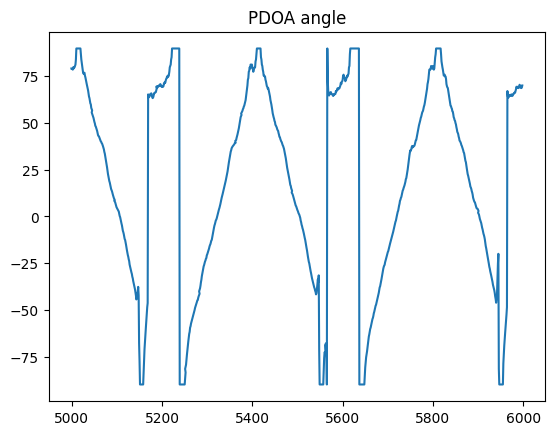

In [40]:
import matplotlib.pyplot as plt
d=cirDisp.show(tag)
plt.plot(d[:,0],d[:,1])
plt.title("PDOA angle")
plt.show()